<h1 align='center'> Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


#Preprocessing libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from contractions import CONTRACTION_MAP #Importing contractions script
import unicodedata
import re

#Vectorizer library.
from keras.preprocessing.text import text_to_word_sequence,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, HashingVectorizer

#evaluation matrices library
from sklearn.metrics import confusion_matrix,f1_score

#LSTM Model
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

from sklearn.feature_selection import chi2

#visulaization:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
#config
random_seed = 123
embed_dim = 256
lstm_out = 196
max_fatures = 2000

In [3]:
filename = 'Twitter_Data.csv'
analysis_df = pd.read_csv(filename,encoding='latin1',usecols=['text','sentiment'])

In [4]:
analysis_df.head()

,text,sentiment
0,when modi promised âminimum government maxim...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [5]:
# convert the sentiments to numeric data.
def ConvertSentiments(_sentiment):
    cvt_sentiment = 0
    if _sentiment == 1:
        cvt_sentiment = 2
    elif _sentiment == 0:
        cvt_sentiment = 1
    else:
        cvt_sentiment = 0
        
    return cvt_sentiment

In [6]:
analysis_df['C_Sentiment'] = analysis_df.sentiment.apply(ConvertSentiments)

In [7]:
print(analysis_df.shape)
analysis_df.head()

(162951, 3)


,text,sentiment,C_Sentiment
0,when modi promised âminimum government maxim...,-1.0,0
1,talk all the nonsense and continue all the dra...,0.0,1
2,what did just say vote for modi welcome bjp t...,1.0,2
3,asking his supporters prefix chowkidar their n...,1.0,2
4,answer who among these the most powerful world...,1.0,2


In [8]:
analysis_df['text'] = analysis_df['text'].astype('category')
analysis_df['C_Sentiment'] = analysis_df['C_Sentiment'].astype('category')
analysis_df['sentiment'] = analysis_df['sentiment'].astype('category')

In [9]:
analysis_df.dtypes

text           category
sentiment      category
C_Sentiment    category
dtype: object

In [10]:
#converting tweets into lower:
analysis_df['text'] = [str(tweets).strip().lower() for tweets in analysis_df['text']]

In [11]:
analysis_df.head()

,text,sentiment,C_Sentiment
0,when modi promised âminimum government maxim...,-1.0,0
1,talk all the nonsense and continue all the dra...,0.0,1
2,what did just say vote for modi welcome bjp t...,1.0,2
3,asking his supporters prefix chowkidar their n...,1.0,2
4,answer who among these the most powerful world...,1.0,2


In [12]:
#Text Preprocessing
#Contractions:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


#Scrub word removal:
def scrub_words(text):
    #Replace \xao characters in text
    text = re.sub('\xa0', ' ', text)
    
    #Replace non ascii / not words and digits
    text = re.sub("(\\W|\\d)",' ',text)
    
    #Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)
    
    #Remove html markup
    text = re.sub("<.*?>", ' ', text)
    return text

#Creating function object to convert ASCII character
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [13]:
analysis_df['text'] = analysis_df.text.apply(expand_contractions)

In [14]:
analysis_df['text'] = analysis_df.text.apply(scrub_words)

In [15]:
analysis_df['text'] = analysis_df.text.apply(remove_accented_chars)

In [16]:
analysis_df.head()

,text,sentiment,C_Sentiment
0,when modi promised a minimum government maxim...,-1.0,0
1,talk all the nonsense and continue all the dra...,0.0,1
2,what did just say vote for modi welcome bjp t...,1.0,2
3,asking his supporters prefix chowkidar their n...,1.0,2
4,answer who among these the most powerful world...,1.0,2


In [17]:
# stopwords:
stopWords = stopwords.words('english')
#add extra stop word
extra_stopWords = ['na','rt','http']
stopWords.extend(extra_stopWords)

In [18]:
print(stopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [19]:
# Tokenization and Stop word removal.
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def Tokenizer_SWR_SL(_text, isLemamtize = False):
    tweets = text_to_word_sequence(_text)
    if isLemamtize:
        tweets = [lemmatizer.lemmatize(word) for word in tweets if not word in stopWords]
    else:
        tweets = [stemmer.stem(word) for word in tweets if not word in stopWords]    
    tweets = ' '.join(tweets)
    
    return tweets

In [20]:
analysis_df['text'] = analysis_df.text.apply(Tokenizer_SWR_SL,True)
analysis_df.head()

,text,sentiment,C_Sentiment
0,modi promis minimum govern maximum governancea...,-1.0,0
1,talk nonsens continu drama vote modi,0.0,1
2,say vote modi welcom bjp told rahul main campa...,1.0,2
3,ask support prefix chowkidar name modi great s...,1.0,2
4,answer among power world leader today trump pu...,1.0,2


In [21]:
# TF-IDF
tfidf_Vec = TfidfVectorizer(max_features=max_fatures,ngram_range=(1,3))
X = tfidf_Vec.fit_transform(analysis_df.text).toarray()

# Count Vectorizer:
# count_Vec = CountVectorizer(max_features=max_fatures,ngram_range=(1,3))
# X = count_Vec.fit_transform(analysis_df.text).toarray()

# HashingVectorizer
# hash_vec = HashingVectorizer(n_features=20)
# X = hash_vec.fit_transform(analysis_df.text).toarray()

#### Use only, if you use IFIDF as vectorizer.

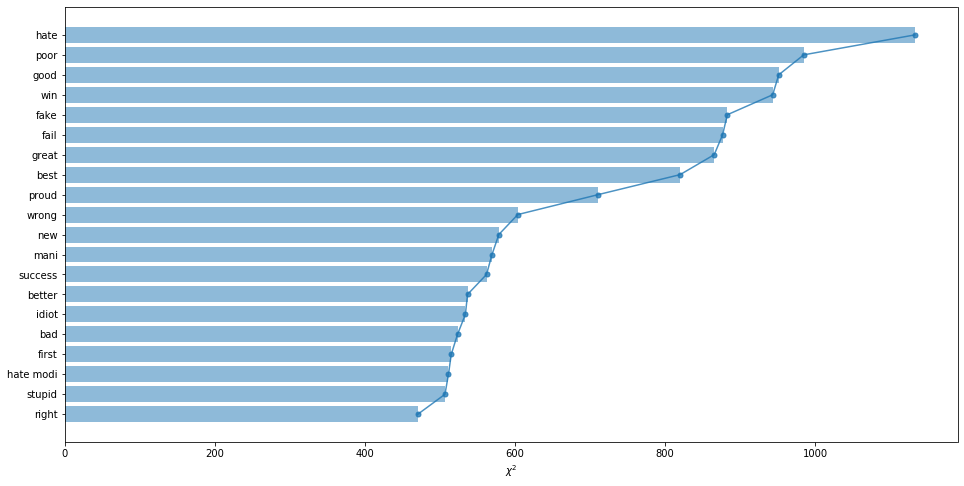

In [22]:
# TF-IDF
tfidf_Vec = TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_tfidf = tfidf_Vec.fit_transform(analysis_df.text)
y_tfidf = analysis_df.C_Sentiment
chi2score = chi2(X_tfidf,y_tfidf)[0]

#Plot
plt.figure(figsize=(16,8))
scores = list(zip(tfidf_Vec.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

In [23]:
X.shape

(162951, 2000)

In [24]:
Y = analysis_df['C_Sentiment']

In [25]:
# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size=0.33, random_state=123)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(109177, 2000)
(53774, 2000)
(109177,)
(53774,)


### Random Forest:

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
# Create the model with 100 trees
Classifier_RF = RandomForestClassifier(criterion='entropy',n_estimators=100,max_depth=100,bootstrap = True,max_features ='sqrt'
                                       ,min_samples_leaf=2,random_state=random_seed)

In [29]:
Classifier_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=100, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [30]:
RF_trainPreds = Classifier_RF.predict(X_train)
print("confusion_matrix on train data\n",confusion_matrix(y_train,RF_trainPreds))
print("\n F1 SCORE = ",f1_score(y_train, RF_trainPreds, average="macro"))

confusion_matrix on train data
 [[15560  5698  2504]
 [  383 35632  1027]
 [  832  7615 39926]]

 F1 SCORE =  0.8220111594669336


In [31]:
RF_testPreds = Classifier_RF.predict(X_test)
print("confusion_matrix on test data\n",confusion_matrix(y_test,RF_testPreds))
print("\n F1 SCORE = ",f1_score(y_test, RF_testPreds, average="macro"))

confusion_matrix on test data
 [[ 6348  2995  2408]
 [  276 17112   768]
 [ 1045  4272 18550]]

 F1 SCORE =  0.7573627952790821


In [32]:
print(RF_testPreds[0:20])

[1 2 2 1 2 0 2 0 1 1 1 1 1 2 2 2 1 2 0 1]


### LSTM

<b>LSTM Embedding layer parameters:</b><br>
<b>input_dim:</b> This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0–10, then the size of the vocabulary would be 11 words.
<br><b>output_dim:</b> This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
<br><b>input_length:</b> This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [33]:
#Tokenizer
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(analysis_df['text'].values)
X = tokenizer.texts_to_sequences(analysis_df['text'].values)
X = pad_sequences(X,maxlen=100)

C:\Users\Navin\anaconda3\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [34]:
model = Sequential()
model.add(Embedding(input_dim = max_fatures,output_dim = embed_dim,input_length = X.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

C:\Users\Navin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
C:\Users\Navin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(196, dropout=0.2, recurrent_dropout=0.2)`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 256)          512000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               355152    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 867,743
Trainable params: 867,743
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
Y = pd.get_dummies(analysis_df['C_Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = random_seed)
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test, test_size = 0.5, random_state = random_seed)

In [36]:
batch_size = 64
model.fit(X_train, Y_train, nb_epoch = 7, batch_size=batch_size, verbose = 2)

C:\Users\Navin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
C:\Users\Navin\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/7
 - 360s - loss: 0.5362 - accuracy: 0.8002
Epoch 2/7
 - 357s - loss: 0.4600 - accuracy: 0.8339
Epoch 3/7
 - 357s - loss: 0.4396 - accuracy: 0.8394
Epoch 4/7
 - 358s - loss: 0.4187 - accuracy: 0.8465
Epoch 5/7
 - 357s - loss: 0.3999 - accuracy: 0.8518
Epoch 6/7
 - 357s - loss: 0.3809 - accuracy: 0.8590
Epoch 7/7
 - 394s - loss: 0.3602 - accuracy: 0.8658


In [37]:
score,acc = model.evaluate(X_train, Y_train, verbose = 2, batch_size = batch_size)
print('Train Data')
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

Train Data
score: 0.31
acc: 0.88


In [38]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print('Test Data')
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

Test Data
score: 0.49
acc: 0.83


In [39]:
pos_cnt, neg_cnt, nut_cnt, pos_correct, neg_correct, nut_correct = 0, 0, 0, 0, 0, 0
for x in range(len(X_val)):
    
    result = model.predict(X_val[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        elif np.argmax(Y_val[x]) == 2:
            nut_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_val[x]) == 0:
        neg_cnt += 1
    elif np.argmax(Y_val[x]) == 2:
        nut_cnt += 1
    else:
        pos_cnt += 1

In [40]:
print('pos_acc', round(pos_correct/pos_cnt*100, 2), '%')
print('neg_acc', round(neg_correct/neg_cnt*100,2), "%")
print('Nuetral_acc', round(nut_correct/nut_cnt*100, 2), '%')

pos_acc 89.85 %
neg_acc 70.91 %
Nuetral_acc 84.2 %
